  #

amit chen


In [75]:
import pandas as pd
import numpy as np
import os
from IPython.core.display import display
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from elections_functions import *
from sklearn.decomposition import PCA
import scipy
# from dim_reduc_internal import show_votes_pca

In [76]:
# pre process:

sns.set(style="dark")

THRESH_HOLD = 0.035

MEREZ = 'מרצ'

EMET = 'אמת'

BADGE_VAADA = 'סמל ועדה'

OUTSIDE_ENEVELOPS = 'מעטפות חיצוניות'

ECO_LEVEL_COL = 'eco_level'

ECO_LEVELS_AMOUNT = 10

NAME_COL = 'name'

ISO_ECNODING_FORMAT = 'iso-8859-8'

HEVRATI_CALCALI_XLSX = 'eshkol_hevrati_calcali.xlsx'

YESHOV_BADGE_COL = 'סמל ישוב'

SET_CODE_COL = "set_code"

party_acrynom_to_name_2020 ={EMET: "עבודה גשר מרצ", 'ג' : "יהדות התורה", 'ודעם'  : "הרשימה המשותפת", 'טב'  : "ימינה",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "כחול לבן", 'שס'  : "שס"}

In [77]:
raw_2020_ballots = pd.read_csv('votes per ballot 2020.csv', encoding ='iso-8859-8', index_col='שם ישוב')
raw_2020_ballots.drop(["מעטפות חיצוניות"], axis=0, inplace=True)
ballots_2020 = raw_2020_ballots.drop(BADGE_VAADA, axis=1)
ballots_2020 = ballots_2020[ballots_2020.columns[8:-1]]
ballots_2020 = ballots_2020.drop(columns='כשרים')
df_2020 = ballots_2020.copy()


In [78]:

def threshold_parties(df, thresh):
    party_ratios = df.sum().div(df.sum().sum()).sort_values(ascending=False)

    return party_ratios[party_ratios > thresh]


above_th_parties = threshold_parties(ballots_2020, 0.0325).index
df_2020_above_th = ballots_2020[above_th_parties]




df_2019b = pd.read_csv('votes per city 2019b.csv', encoding ='iso-8859-8', index_col='שם ישוב')

parse_dict = {}


for i in range(len(df_2019b.index)):
    df_indexes = df_2019b.index[i]
    df_inx_post_ptrn1 = df_indexes.replace('-',"")
    df_indexes_pst_ptrn2 = df_inx_post_ptrn1.replace("\'", "")
    df_indexes_post_ptrn3 = df_indexes_pst_ptrn2.replace("\"", "")

    parse_dict[df_2019b.index[i]] = df_indexes_post_ptrn3


Dropping the needless columns

In [79]:

df_2019b = df_2019b.rename(index=parse_dict)
df_2019b = df_2019b.drop([OUTSIDE_ENEVELOPS])
df_2019 = df_2019b.drop(BADGE_VAADA, axis=1)

df_2019 = df_2019[df_2019.columns[5:]]
df_2019 = df_2019.sort_index()
df_2019b = df_2019b.sort_index()
df_2019[EMET] = df_2019[MEREZ] + df_2019[EMET]
df_2019= df_2019.drop(columns=[MEREZ], axis=1)
df_2019['נץ'] = df_2019['כף']
df_2019 = df_2019.drop(columns=['כף'], axis=1)


Combining Merez Emet Avoda
Changing Yahadot a Tora name

Getting above threshold parties

In [80]:
pjs = df_2020_above_th.sum(axis=0) / df_2020_above_th.values.sum()

above_th_parties19 = threshold_parties(df_2019, THRESH_HOLD)
above_th_parties19 = above_th_parties19.reindex(pjs.index, axis=1)

# Path to datafiles - change to your directory!
DATA_PATH = ''
ELECTIONS = "בחירות 2020 או 2019 ב"

In [81]:
# Helper functions: you can use and modify
# Draw 1*3 plots
def subplot_bars(x, y, title_str):
    width = 0.35
    fig, axs = plt.subplots(3, figsize=(25, 10))
    for i in range(3): # loop on plots
        axs[i].bar(np.arange(9), x[i,:], width, color='b')
        axs[i].bar(np.arange(9)+width, y[i,:], width, color='r')
        axs[i].set_title(title_str[i][::-1], fontsize=24)
        axs[i].set_xticks(np.arange(9))
    plt.show()

In [82]:
def plop():
    df_2020, df_2020_raw = read_election_results('2020', 'city')
    df_2019b, df_2019b_raw = read_election_results('2019b', 'city')
    df_2020_raw = df_2020_raw[df_2020_raw.index != 'מעטפות חיצוניות']
    df_2019b_raw = df_2019b_raw[df_2019b_raw.index != 'מעטפות חיצוניות']
    df_2020_big = df_2020[big_parties_2020]
    df_2019b_big = df_2019b[big_parties_2019b]
    df_2019b_big['אמת'] = df_2019b_big[['מרצ', 'אמת']].sum(axis=1)
    df_2019b_big['נץ'] = df_2019b_big['כף']
    df_2019b_big = df_2019b_big.drop(['מרצ', 'כף'], axis=1)
    df_combined = pd.concat([df_2019b_big, df_2020_big])
    df_combined_ratios = df_combined / np.array(df_combined.sum(axis=1)).reshape(-1, 1)
    pca = do_PCA(df_combined_ratios).T
    df_combined_ratios['PC1'] = pca[0]
    df_combined_ratios['PC2'] = pca[1]
    a = np.vstack([np.array(df_2020_raw['בזב']), np.array(df_2019b_raw['בזב'])])
    df_combined_ratios['בזב'] = a.flatten()
    df_combined_ratios[ELECTIONS] = np.vstack([np.ones((1213,)), np.zeros((1213,))]).flatten()
    return df_2019b_big, df_2020_big, df_combined_ratios

In [83]:
def do_PCA(df, order=2):

    pca = PCA(n_components=order)  # define PCA object
    X_pca = pca.fit_transform(df)  # fit model. Compute principal components
    return X_pca

In [84]:
def Seaborn_scatter(X_DF, name, title, Arrow=False,big_three=[]):
    plt.figure(figsize=(16.3, 13))
    p1 = sns.scatterplot(data=X_DF, x="PC1", y="PC2", marker="o", hue=ELECTIONS, size='בזב'
                         ,alpha=0.87, legend=False)
    if Arrow:
        X_DF_a = X_DF[['PC1', 'PC2']].iloc[:X_DF.shape[0]//2]
        X_DF_b = X_DF[['PC1', 'PC2']].iloc[X_DF.shape[0]//2:]
        for x1, y1, x2, y2, name in zip(X_DF_a['PC1'], X_DF_a['PC2'],X_DF_b['PC1'],X_DF_b['PC2'], X_DF_a.index):
            if name in big_three:
                plt.arrow(x1, y1, x2 - x1, y2 - y1, color='red')
                plt.annotate(name[::-1],(x1, y1))
                plt.annotate(name[::-1],(x2, y2))
            else:
                plt.arrow(x1, y1, x2-x1, y2-y1)

    plt.title(title)
    p1.set_xlabel("PC1")
    p1.set_ylabel("PC2")
    plt.savefig(name)
    plt.show()


In [85]:
def Q_2_v_subplot(x, y, title_str):
    x = np.array(x)
    y = np.array(y)
    width = 0.35
    fig, axs = plt.subplots(3, figsize=(25, 10))
    for i in range(3): # loop on plots
        axs[i].bar(np.arange(9), x[i,:], width, color='b')
        axs[i].bar(np.arange(9)+width, y[i,:], width, color='r')
        axs[i].set_title(title_str[i][::-1], fontsize=24)
        axs[i].set_xticks(np.arange(9))
    plt.show()

In [86]:
def subplot_bars_2(x, y):
    x = np.array(x)
    y = np.array(y)
    width = 0.35
    fig, axs = plt.subplots(2, 5, figsize=(25, 10))
    for i in range(10):  # loop on plots
        axs[i//5, i % 5].bar(np.arange(5), x[i,:], width, color='b')
        axs[i//5, i % 5].bar(np.arange(5)+width, y[i,:], width, color='r')
        #axs[i//5, i % 5].set_title(title_str[i], fontsize=24)
        if i in [0, 5]:
            axs[i // 5, i % 5].set_ylabel('Votes percent', fontsize=24)
        #axs[i // 5, i % 5].legend(legend_str[i])
    plt.show()

In [87]:



df_2020_ballot, df_2020_raw_ballot = read_election_results('2020', 'ballot')
df_2019b_ballot, df_2019b_raw_ballot = read_election_results('2019b', 'ballot')
b2020 = adapt_df(df_2020_raw_ballot, list(parties_dict_2020.keys()), include_no_vote=False,
                    ballot_number_field_name='קלפי')
b2019b = adapt_df(df_2019b_raw_ballot, list(parties_dict_2019b.keys()), include_no_vote=False,
                    ballot_number_field_name='קלפי')
b2019b['נץ'] = b2019b['כף']
b2019b = b2019b.drop(['כף'], axis=1)
new_data_frame = pd.DataFrame(index=b2019b.index)
new_data_frame['ישוב'] = b2019b['ישוב'].copy()
b2019b.drop('ישוב', axis=1, inplace=True) # drop column
b2020.drop('ישוב', axis=1, inplace=True) # drop column
combined = pd.merge(b2020, b2019b, how='inner', left_index=True, right_index=True)

N_a_2020 = combined.iloc[:, :9]
N_b_2019b = combined.iloc[:, 9:]
a = N_b_2019b['מרצ'].copy()
b = N_b_2019b['נץ_y'].copy()
N_b_2019b['מרצ'] = b
N_b_2019b['נץ_y'] = a
display(N_a_2020)
display(N_b_2019b)
M, res, rank, a = np.linalg.lstsq(N_b_2019b,N_a_2020)


,אמת_x,ג_x,ודעם_x,טב_x,ל_x,מחל_x,נץ_x,פה_x,שס_x
ballot_id,,,,,,,,,
967__1.0,2,0,112,0,0,1,0,6,2
967__2.0,6,0,235,0,0,2,0,0,0
967__3.0,5,0,207,0,1,1,0,2,0
472__8.0,5,3,205,1,1,26,0,8,0
472__7.0,6,0,260,0,1,32,0,17,1
...,...,...,...,...,...,...,...,...,...
3563__2.0,10,14,2,174,15,227,9,27,11
3563__3.0,7,8,0,301,10,188,9,25,13
970__1.0,0,0,43,0,0,0,0,4,0


,אמת_y,ג_y,ודעם_y,טב_y,ל_y,מחל_y,מרצ,פה_y,שס_y,נץ_y
ballot_id,,,,,,,,,,
967__1.0,0,1,100,0,0,0,0,9,0,0
967__2.0,3,0,202,0,0,2,0,12,0,0
967__3.0,0,0,196,0,0,1,0,1,0,0
472__8.0,2,3,148,0,1,6,1,27,3,6
472__7.0,2,0,194,1,3,18,0,43,12,6
...,...,...,...,...,...,...,...,...,...,...
3563__2.0,13,14,1,176,21,166,28,19,11,2
3563__3.0,9,3,0,308,6,133,39,25,12,0
970__1.0,0,0,25,0,0,2,0,6,0,0


C:\Users\amitc\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



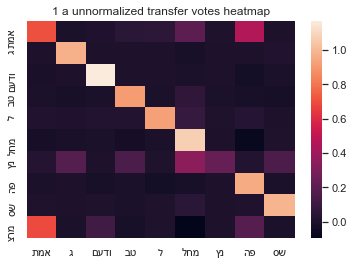

In [88]:
names_2019 = [name[::-1] for name in b2019b.columns]
a = names_2019[6]
b = names_2019[9]
names_2019[6] = b
names_2019[9] = a
pd_M = pd.DataFrame(M)
pd_M = pd_M.set_index(pd.Series(names_2019))
pd_M = pd_M.set_axis(pd.Series([name[::-1] for name in b2020.columns]),axis=1)
sns.heatmap(pd_M,xticklabels=True,yticklabels=True)
plt.title('1 a unnormalized transfer votes heatmap')

M_q1_1 = pd_M.copy()

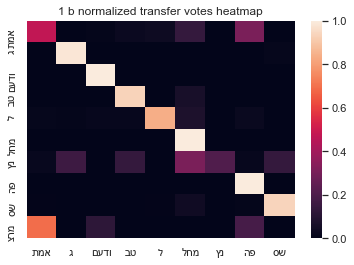

In [89]:
pd_M[pd_M<0.005] = 0
pd_M = pd_M/np.array(pd_M.sum(axis=1)).reshape(-1,1)
sns.heatmap(pd_M,xticklabels=True,yticklabels=True)
plt.title('1 b normalized transfer votes heatmap')

M_q1_2 = pd_M.copy()


אמת ומחל אמת ופה נץ וטב פה ומחל הכול אבל לא גבוה במיוחד.

C:\Users\amitc\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



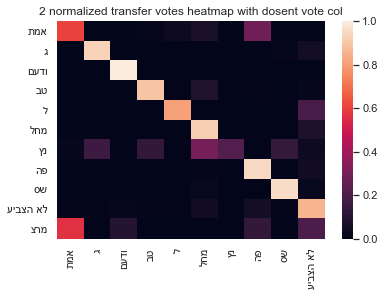

In [90]:
#question 2
b2020 = adapt_df(df_2020_raw_ballot, list(parties_dict_2020.keys()), include_no_vote=True,
                    ballot_number_field_name='קלפי')
b2019b = adapt_df(df_2019b_raw_ballot, list(parties_dict_2019b.keys()), include_no_vote=True,
                    ballot_number_field_name='קלפי')
b2019b['נץ'] = b2019b['כף']
b2019b = b2019b.drop(['כף'], axis=1)
new_data_frame = pd.DataFrame(index=b2019b.index)
new_data_frame['ישוב'] = b2019b['ישוב'].copy()
b2019b.drop('ישוב', axis=1, inplace=True) # drop column
b2020.drop('ישוב', axis=1, inplace=True) # drop column
combined = pd.merge(b2020, b2019b, how='inner', left_index=True, right_index=True)

N_a_2020 = combined.iloc[:, :10]
N_b_2019b = combined.iloc[:, 10:]
a = N_b_2019b['מרצ'].copy()
b = N_b_2019b['נץ_y'].copy()
N_b_2019b['מרצ'] = b
N_b_2019b['נץ_y'] = a

M, res, rank, a = np.linalg.lstsq(N_b_2019b,N_a_2020)
names_2019 = [name[::-1] for name in b2019b.columns]
a = names_2019[6]
b = names_2019[10]
names_2019[6] = b
names_2019[10] = a

pd_M = pd.DataFrame(M)
pd_M = pd_M.set_index(pd.Series(names_2019))
pd_M = pd_M.set_axis(pd.Series([name[::-1] for name in b2020.columns]),axis=1)
pd_M[pd_M<0.005] = 0
pd_M = pd_M/np.array(pd_M.sum(axis=1)).reshape(-1,1)
sns.heatmap(pd_M,xticklabels=True,yticklabels=True)
plt.title('2 normalized transfer votes heatmap with dosent vote col')

M_q2_1 = pd_M.copy()


Text(0.5, 1, 'q3 normalized transfer votes heatmap nnls')

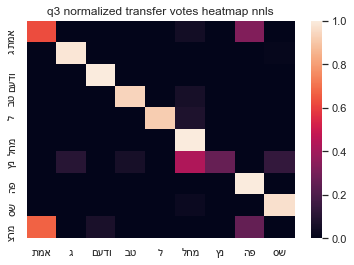

In [91]:
#question 3
df_2020_ballot, df_2020_raw_ballot = read_election_results('2020', 'ballot')
df_2019b_ballot, df_2019b_raw_ballot = read_election_results('2019b', 'ballot')
b2020 = adapt_df(df_2020_raw_ballot, list(parties_dict_2020.keys()), include_no_vote=False,
                    ballot_number_field_name='קלפי')
b2019b = adapt_df(df_2019b_raw_ballot, list(parties_dict_2019b.keys()), include_no_vote=False,
                    ballot_number_field_name='קלפי')
b2019b['נץ'] = b2019b['כף']
b2019b = b2019b.drop(['כף'], axis=1)
new_data_frame = pd.DataFrame(index=b2019b.index)
new_data_frame['ישוב'] = b2019b['ישוב'].copy()
b2019b.drop('ישוב', axis=1, inplace=True) # drop column
b2020.drop('ישוב', axis=1, inplace=True) # drop column
combined = pd.merge(b2020, b2019b, how='inner', left_index=True, right_index=True)

N_a_2020 = combined.iloc[:, :9]
N_b_2019b = combined.iloc[:, 9:]
a = N_b_2019b['מרצ'].copy()
b = N_b_2019b['נץ_y'].copy()
N_b_2019b['מרצ'] = b
N_b_2019b['נץ_y'] = a
a = []
[a.append(scipy.optimize.nnls(N_b_2019b, b)[0]) for b in N_a_2020.T.to_numpy()]
M = np.vstack(a)
names_2019 = [name[::-1] for name in b2019b.columns]
a = names_2019[6]
b = names_2019[9]
names_2019[6] = b
names_2019[9] = a
pd_M = pd.DataFrame(M).T
pd_M = pd_M.set_index(pd.Series(names_2019))
pd_M = pd_M.set_axis(pd.Series([name[::-1] for name in b2020.columns]),axis=1)
pd_M[pd_M<0.005] = 0

M_q3_1 = pd_M.copy()

pd_M = pd_M/np.array(pd_M.sum(axis=1)).reshape(-1,1)
sns.heatmap(pd_M,xticklabels=True,yticklabels=True)
plt.title('q3 normalized transfer votes heatmap nnls')


 שס לשס עלה אמת לאמת עלה מחל למחל עלה ל לל עלה ופה ואמת עלה

C:\Users\amitc\anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



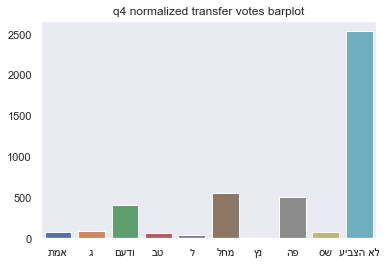

In [92]:
#q4
#question 2
b2020 = adapt_df(df_2020_raw_ballot, list(parties_dict_2020.keys()), include_no_vote=True,
                    ballot_number_field_name='קלפי')
b2019b = adapt_df(df_2019b_raw_ballot, list(parties_dict_2019b.keys()), include_no_vote=True,
                    ballot_number_field_name='קלפי')
b2019b['נץ'] = b2019b['כף']
b2019b = b2019b.drop(['כף'], axis=1)
new_data_frame = pd.DataFrame(index=b2019b.index)
new_data_frame['ישוב'] = b2019b['ישוב'].copy()
b2019b.drop('ישוב', axis=1, inplace=True) # drop column
b2020.drop('ישוב', axis=1, inplace=True) # drop column
combined = pd.merge(b2020, b2019b, how='inner', left_index=True, right_index=True)

N_a_2020 = combined.iloc[:, :10]
N_b_2019b = combined.iloc[:, 10:]
a = N_b_2019b['מרצ'].copy()
b = N_b_2019b['נץ_y'].copy()
N_b_2019b['מרצ'] = b
N_b_2019b['נץ_y'] = a

M, res, rank, a = np.linalg.lstsq(N_b_2019b,N_a_2020)
names_2019 = [name[::-1] for name in b2019b.columns]
a = names_2019[6]
b = names_2019[10]
names_2019[6] = b
names_2019[10] = a
a = (N_b_2019b@M).to_numpy() -N_a_2020.to_numpy() 
a = np.square(a)
a = a.sum(axis=0)/10047
b2020.columns
a = pd.DataFrame(a.reshape(1,-1))
a = a.set_axis(pd.Series([name[::-1] for name in b2020.columns]),axis=1)
plt.title('q4 normalized transfer votes barplot')
sns.barplot(data=a)

מצליח לחזות היטב עבור מפלגת ל נץ טב ג אמת ושס, עבור מחל פה וודעם ככה ככה אבל הן בפער הכי גדולות ולא הצביע מאוד לא מצליח אבל זה בעיקר בגלל שהשיטה שבא אנחנו משיגים אותו היא מאוד שנויה במחלוקת.

# bonus cell 
# bonus cell
# bonus cell!  you agreed this after the mail we sent you about it :) 

בקוד הבא ניתן לראות את גרף sankey plot תחת וריאציית המעברים עבור שאלה 1 סעיף 1

In [93]:
import plotly.graph_objects as go
import plotly.express as px


current_q = M_q1_1
combined_names =  [" 2019 " + name  for name in list(current_q.index)] +\
                 [" 2020 " + name for name in list(current_q.columns)]
combined_names = pd.DataFrame(combined_names)
#display(combined_names)
#display(current_q)

# source = np.tile(np.arange(0,11), (10,1)).T.flatten()
# target = np.tile(np.arange(11,21), 11)

source = np.tile(np.arange(0,10), (9,1)).T.flatten()
#print(source)
target = np.tile(np.arange(10,19), 10)
#print(target)
colors = px.colors.qualitative.Set3[:-2]
color_node = colors + colors[:8] + colors[10:] + [colors[8]]
np_color = np.tile(np.array(colors), (9,1)).T.flatten()
#print(np_color)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 5,
      line = dict(color = "black", width = 2),
      label = combined_names,  # parties names
      color = color_node
    ),
    link = dict(
        # from 0-10 is 2019. from 11-20 is 2020 print
      source = source, # 2019
      target = target,  # 2020
      value = current_q.to_numpy().flatten(),
      color = np_color
  ))])

fig.update_layout(title_text="Elections votes transition Q1_1", font_size=10)
fig.show()


בקוד הבא ניתן לראות את גרף sankey plot תחת וריאציית המעברים עבור שאלה 1 סעיף 2

In [94]:



current_q = M_q1_2
combined_names =  [" 2019 " + name  for name in list(current_q.index)] +\
                 [" 2020 " + name for name in list(current_q.columns)]
combined_names = pd.DataFrame(combined_names)
#display(combined_names)
#display(current_q)

# source = np.tile(np.arange(0,11), (10,1)).T.flatten()
# target = np.tile(np.arange(11,21), 11)

source = np.tile(np.arange(0,10), (9,1)).T.flatten()
#print(source)
target = np.tile(np.arange(10,19), 10)
#print(target)
colors = px.colors.qualitative.Set3[:-2]
color_node = colors + colors[:8] + colors[10:] + [colors[8]]
np_color = np.tile(np.array(colors), (9,1)).T.flatten()
#print(np_color)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 5,
      line = dict(color = "black", width = 2),
      label = combined_names,  # parties names
      color = color_node
    ),
    link = dict(
        # from 0-10 is 2019. from 11-20 is 2020 print
      source = source, # 2019
      target = target,  # 2020
      value = current_q.to_numpy().flatten(),
      color = np_color
  ))])

fig.update_layout(title_text="Elections votes transition Q1_2", font_size=10)
fig.show()



בקוד הבא ניתן לראות את גרף sankey plot תחת וריאציית המעברים עבור שאלה 2

In [95]:


special_6 = M_q2_1.iloc[6].copy()
special_10 = M_q2_1.iloc[10].copy()
M_q2_1.iloc[6]= M_q2_1.iloc[10]
M_q2_1.iloc[10]= special_6

combined_names =  [" 2019 " + name[::-1]  for name in b2019b.columns] +\
                 [" 2020 " + name[::-1] for name in b2020.columns]
combined_names = pd.DataFrame(combined_names)
display(combined_names)
display(pd_M)
#display(M_q2_1)

source = np.tile(np.arange(0,11), (10,1)).T.flatten()
target = np.tile(np.arange(11,21), 11)
colors = px.colors.qualitative.Set3[:-1]
color_node = colors + colors[:9] + colors[11:] + [colors[9]]
np_color = np.tile(np.array(colors), (10,1)).T.flatten()
#print(np_color)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 5,
      line = dict(color = "black", width = 2),
      label = combined_names,  # parties names
      color = color_node
    ),
    link = dict(
        # from 0-10 is 2019. from 11-20 is 2020 print
      source = source, # 2019
      target = target,  # 2020
      value = M_q2_1.to_numpy().flatten(),
      color = np_color
  ))])

fig.update_layout(title_text="Elections votes transition Q2", font_size=10)
fig.show()


,0
0,2019 תמא
1,2019 ג
2,2019 םעדו
3,2019 בט
4,2019 ל
5,2019 לחמ
6,2019 צרמ
7,2019 הפ
8,2019 סש
9,2019 עיבצה אל


,תמא,ג,םעדו,בט,ל,לחמ,ץנ,הפ,סש
תמא,0.625616,0.000000,0.000000,0.000000,0.000000,0.049563,0.000000,0.324822,0.000000
ג,0.000000,0.985003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014997
םעדו,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
בט,0.000000,0.000000,0.000000,0.938737,0.000000,0.061263,0.000000,0.000000,0.000000
ל,0.000000,0.000000,0.000000,0.000000,0.917972,0.082028,0.000000,0.000000,0.000000
לחמ,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ץנ,0.000000,0.105131,0.000000,0.060066,0.000000,0.433144,0.265413,0.000000,0.136246
הפ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
סש,0.000000,0.000000,0.000000,0.000000,0.000000,0.028668,0.000000,0.000000,0.971332
צרמ,0.669913,0.000000,0.068872,0.000000,0.000000,0.000000,0.000000,0.261215,0.000000


בקוד הבא ניתן לראות את גרף sankey plot תחת וריאציית המעברים עבור שאלה 3

In [96]:
current_q = M_q3_1
combined_names =  [" 2019 " + name  for name in list(current_q.index)] +\
                 [" 2020 " + name for name in list(current_q.columns)]
combined_names = pd.DataFrame(combined_names)
#display(combined_names)
#display(current_q)

# source = np.tile(np.arange(0,11), (10,1)).T.flatten()
# target = np.tile(np.arange(11,21), 11)

source = np.tile(np.arange(0,10), (9,1)).T.flatten()
#print(source)
target = np.tile(np.arange(10,19), 10)
#print(target)
colors = px.colors.qualitative.Set3[:-2]
color_node = colors + colors[:8] + colors[10:] + [colors[8]]
np_color = np.tile(np.array(colors), (9,1)).T.flatten()
#print(np_color)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 5,
      line = dict(color = "black", width = 2),
      label = combined_names,  # parties names
      color = color_node
    ),
    link = dict(
        # from 0-10 is 2019. from 11-20 is 2020 print
      source = source, # 2019
      target = target,  # 2020
      value = current_q.to_numpy().flatten(),
      color = np_color
  ))])

fig.update_layout(title_text="Elections votes transition Q3", font_size=10)
fig.show()


לסיכום, ראינו כי הגרפים מתארים באופן מדוייק בורור, ואף נעים לעין, את השינויים המשמעותיים בבחירות ולכן נעדיף להשתמש בהם על פני מפות החום את הפיזור, בכל סיטואציה אפשרית, חרף אילוצי הזמן
